In [14]:
import time

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.datasets import CIFAR10

In [15]:
batch_size = 128
learning_rate = 0.0001
num_epochs = 1
num_classes = 10
classes = (
    "Airplane",
    "Car",
    "Bird",
    "Cat",
    "Deer",
    "Dog",
    "Frog",
    "Horse",
    "Ship",
    "Truck",
)

# check if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [16]:
# Define the transformation to apply to the data
transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.ToTensor(),  # Convert PIL Image to tensor  [0.0, 1.0]
        # Normalize the data
        transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(1.0, 1.0, 1.0)),
    ]
)

# Load the CIFAR-10 training dataset
train_data = CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(
    train_data, batch_size=batch_size, shuffle=True, num_workers=2
)

# Load the CIFAR-10 testing dataset
test_data = CIFAR10(root="./data", train=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [17]:
# Checking the dataset
print("Training Set:")
for images, labels in train_loader:
    print("Image batch dimensions:", images.size())
    print("Image label dimensions:", labels.size())
    print(labels[:10])
    break

# Checking the dataset
print("Testing Set:")
for images, labels in train_loader:
    print("Image batch dimensions:", images.size())
    print("Image label dimensions:", labels.size())
    print(labels[:10])
    break

Training Set:
Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])
tensor([2, 1, 7, 4, 9, 6, 6, 7, 2, 3])
Testing Set:
Image batch dimensions: torch.Size([128, 3, 224, 224])
Image label dimensions: torch.Size([128])
tensor([7, 2, 2, 7, 0, 9, 2, 9, 4, 1])


![alexnet-paper.png](https://jgox-image-1316409677.cos.ap-guangzhou.myqcloud.com/blog/alexnet-paper.png)

In [18]:
class AlexNet(nn.Module):

    def __init__(self, num_classes=num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1, groups=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, groups=2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, groups=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [19]:
model = AlexNet()
model.to(device)

loss_fn = loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [20]:
def compute_accuracy(model, data_loader):
    model.eval()
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):
            features = features.to(device)
            targets = targets.to(device)

            # compute the model output
            outputs = model(features)
            _, predicted_labels = torch.max(outputs, 1)

            # stat the correct radix
            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()
    return correct_pred * 1.0 / num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0.0, 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)
            outputs = model(features)
            loss = F.cross_entropy(outputs, targets, reduction="sum")
            num_examples += targets.size(0)
            curr_loss += loss

    curr_loss = curr_loss / num_examples
    return curr_loss

In [21]:
# train model
log_dict = {
    "train_loss_per_batch": [],
    "train_acc_per_epoch": [],
    "train_loss_per_epoch": [],
}
start_time = time.time()
for epoch in range(num_epochs):  
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader, 0):
        features = features.to(device)
        targets = targets.to(device)

        # FORWARD AND BACK PROP
        outputs = model(features)
        loss = loss_fn(outputs, targets)
        optimizer.zero_grad()

        loss.backward()

        # UPDATE MODEL PARAMETERS
        optimizer.step()

        # LOGGING
        log_dict["train_loss_per_batch"].append(loss.item())
        if not batch_idx % 50:
            print(
                f"Epoch: {epoch+1:03d}/{num_epochs:03d} | Batch {batch_idx:04d}/{len(train_loader):04d} | Loss: {loss:.4f}"
            )

    model.eval()

    with torch.set_grad_enabled(False):  # save memory during inference
        train_acc = compute_accuracy(model, train_loader)
        train_loss = compute_epoch_loss(model, train_loader)
        print(
            f"***Epoch: {epoch+1:03d}/{num_epochs:03d} | Train. Acc.: {train_acc:.3f}% | Loss: {train_loss:.3f}"
        )
        log_dict["train_loss_per_epoch"].append(train_loss.item())
        log_dict["train_acc_per_epoch"].append(train_acc.item())

    print(f"Time elapsed: {(time.time() - start_time) / 60:.2f} min")

print(f"Total Training Time: {(time.time() - start_time)/ 60:.2f} min")

Epoch: 001/001 | Batch 0000/0391 | Loss: 2.3044
Epoch: 001/001 | Batch 0050/0391 | Loss: 1.9589
Epoch: 001/001 | Batch 0100/0391 | Loss: 1.6266
Epoch: 001/001 | Batch 0150/0391 | Loss: 1.5510
Epoch: 001/001 | Batch 0200/0391 | Loss: 1.4305
Epoch: 001/001 | Batch 0250/0391 | Loss: 1.4650
Epoch: 001/001 | Batch 0300/0391 | Loss: 1.3620
Epoch: 001/001 | Batch 0350/0391 | Loss: 1.3376
***Epoch: 001/001 | Train. Acc.: 53.394% | Loss: 1.286
Time elapsed: 2.29 min
Total Training Time: 2.29 min


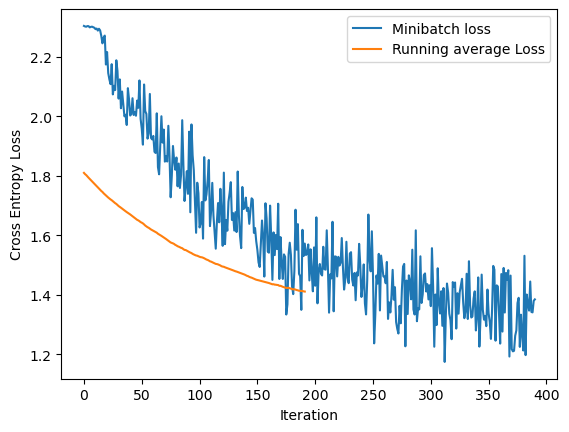

In [22]:
loss_list = log_dict["train_loss_per_batch"]

plt.plot(loss_list, label="Minibatch loss")
plt.plot(
    np.convolve(
        loss_list,
        np.ones(200,) / 200,
        mode="valid",
    ),
    label="Running average Loss",
)

plt.ylabel("Cross Entropy Loss")
plt.xlabel("Iteration")
plt.legend()
plt.savefig("cross_entropy_loss.svg", format="svg")
plt.show()
plt.close()

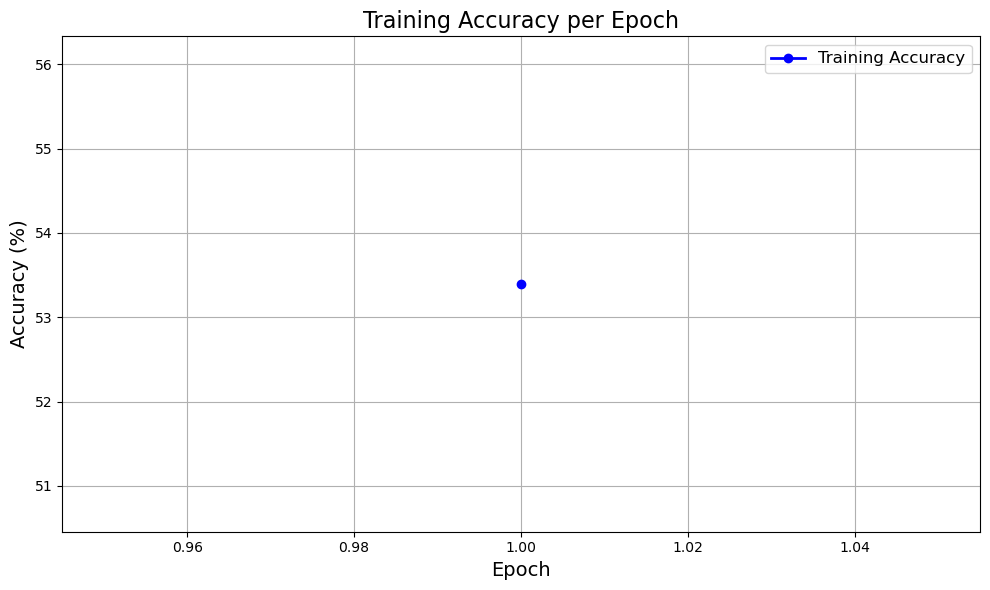

In [23]:
plt.figure(figsize=(10, 6)) 
plt.plot(
    np.arange(1, num_epochs + 1),
    log_dict["train_acc_per_epoch"],
    label="Training Accuracy",
    color="blue",  
    linestyle="-",  
    marker="o",  
    markersize=6,  
    linewidth=2,  
)

plt.xlabel("Epoch", fontsize=14)  
plt.ylabel("Accuracy (%)", fontsize=14)  
plt.title("Training Accuracy per Epoch", fontsize=16)  
plt.legend(loc="best", fontsize=12)  

plt.grid(True)  
plt.tight_layout()  

# 保存图像
plt.savefig("accuracy.svg", format="svg") 
plt.show()  

In [24]:
with torch.set_grad_enabled(False):
    train_acc = compute_accuracy(model=model, data_loader=train_loader)
    test_acc = compute_accuracy(model=model, data_loader=test_loader)


print(f"Train ACC: {train_acc:.2f}%")
print(f"Test ACC: {test_acc:.2f}%")

Train ACC: 53.39%
Test ACC: 52.68%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

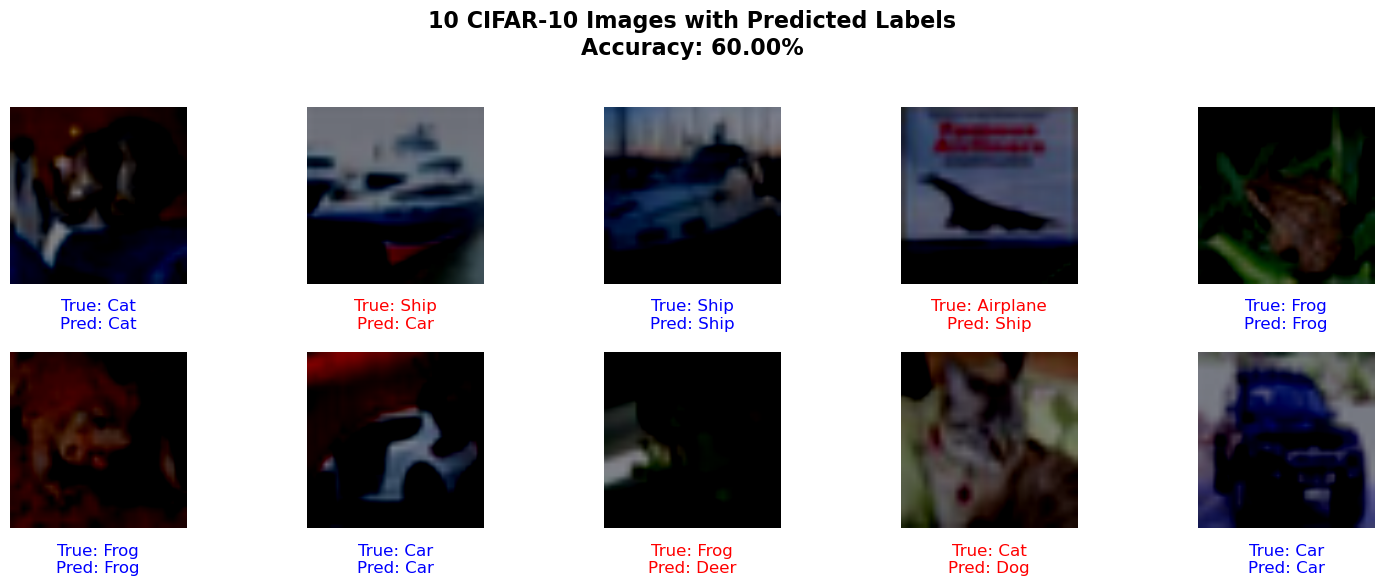

In [41]:
def plot_random_images_with_predictions(model, data_loader, classes):
    model.eval()

    images, labels = next(iter(data_loader))
    images, labels = images[:10], labels[:10]

    images = images.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu()
    labels = labels.cpu()
    predicted = predicted.cpu()

    correct_count = (predicted == labels).sum().item()
    accuracy = correct_count / len(labels) * 100

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(
        f"10 CIFAR-10 Images with Predicted Labels\nAccuracy: {accuracy:.2f}%",
        fontsize=16,
        fontweight=600,
    )
    plt.subplots_adjust(top=0.85)

    for i in range(10):
        ax = axes[i // 5, i % 5]
        img = np.transpose(images[i].numpy(), (1, 2, 0))

        ax.imshow(img)
        ax.axis("off")

        label = classes[labels[i]]
        prediction = classes[predicted[i]]
        color = "blue" if predicted[i] == labels[i] else "red"
        ax.set_title(
            f"True: {label}\nPred: {prediction}",
            fontsize=12,
            color=color,
            loc="center",
            y=-0.3,
        )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_random_images_with_predictions(model, test_loader, classes)